# Projet 7 : Réalisez des indexations automatiques d’images
# <u>B. Classification des images avec méthodes supervisées</u> <br/>

# Le contexte

Pour aider une association de protection des animaux, nous mettons en place une solution de détéction automatique de la race d'un chien à partir d'une photo de celui-ci. Nous essayerons une approche classique dans un premier temps, puis une approche basée sur les réseaux de neurones.

Dans ce notebook nous allons essayer les approches classiques d'apprentissage supervisées avec les techniques d'extractions des features dans les images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import  KNeighborsClassifier

from glob import glob
import scipy
from skimage.io import imread
from skimage import exposure
from skimage import img_as_ubyte
from skimage.filters import gaussian
import cv2

warnings.filterwarnings("ignore")

In [2]:
print('OpenCV Version',cv2.__version__)

OpenCV Version 3.4.1


# 1. Préparation des données

## 1.1 Configuration des noms de répertoires

In [3]:
DATA_DIR = 'data'
TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'

Les images sont chargées à partir du chemin spécifié.<br/>
Les images doivent être rangés dans un dossier dont le nom contient la race correspondante<br/>
 \- breed<br/>
&nbsp;&nbsp;&nbsp;      \--- image 1 <br/>
&nbsp;&nbsp;&nbsp;      \--- image 2<br/>

## 1.2 Chargement données entrainement et tests

In [4]:
train_df = pd.read_csv(TRAIN_DIR + '/images_infos.csv')
train_df['filepath'] = TRAIN_DIR + '/' + train_df['filepath'].astype(str)
test_df = pd.read_csv(TEST_DIR + '/images_infos.csv')
test_df['filepath'] = TEST_DIR + '/' + test_df['filepath'].astype(str)

In [5]:
display(train_df.head())
print("Train size : " + str(train_df.shape[0]))

,filepath,breed
0,data/train/Maltese_dog/n02085936_2927rotate.jpg,Maltese_dog
1,data/train/Maltese_dog/n02085936_4474_crop.jpg,Maltese_dog
2,data/train/Maltese_dog/n02085936_1390rotate.jpg,Maltese_dog
3,data/train/Maltese_dog/n02085936_7537_flip.jpg,Maltese_dog
4,data/train/Maltese_dog/n02085936_1288_crop.jpg,Maltese_dog


Train size : 2000


=> Nous avons 2000 images pour notre entrainement (avec les images augmentées)

In [6]:
display(test_df.head())
print("Test size : " + str(test_df.shape[0]))

,filepath,breed
0,data/test/Maltese_dog/n02085936_17990_crop.jpg,Maltese_dog
1,data/test/Maltese_dog/n02085936_8350_crop.jpg,Maltese_dog
2,data/test/Maltese_dog/n02085936_6348_crop.jpg,Maltese_dog
3,data/test/Maltese_dog/n02085936_20076_crop.jpg,Maltese_dog
4,data/test/Maltese_dog/n02085936_1739_crop.jpg,Maltese_dog


Test size : 354


=> Nous avons 354 images pour les tests.

## 1.3 Numérisation de la variable race de chien

- Conversion de la donnée race de chien en format numérique pour pouvoir ensuite appliquer nos algorithmes.

Pour pouvoir appliquer nos algorithmes d'apprentissage nous allons numériser le nom de la race.

In [7]:
lb_breed = LabelEncoder()
train_df['breed_code'] = lb_breed.fit_transform(train_df["breed"])
test_df['breed_code'] = lb_breed.transform(test_df["breed"])
train_df.head()

,filepath,breed,breed_code
0,data/train/Maltese_dog/n02085936_2927rotate.jpg,Maltese_dog,1
1,data/train/Maltese_dog/n02085936_4474_crop.jpg,Maltese_dog,1
2,data/train/Maltese_dog/n02085936_1390rotate.jpg,Maltese_dog,1
3,data/train/Maltese_dog/n02085936_7537_flip.jpg,Maltese_dog,1
4,data/train/Maltese_dog/n02085936_1288_crop.jpg,Maltese_dog,1


- Méthode pour retrouver le nom de la race à partir de la valeure numérique

In [8]:
'''
Méthode qui retourne le nom de la race associé à la valeur numérique
'''
def decodeLabel(num_label) :
    #warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    l = lb_breed.inverse_transform(num_label)
    #warnings.resetwarnings()
    return l

Stockons les noms des races de chiens dans une liste.

In [9]:
max_code = max(train_df['breed_code'])
breed_names = decodeLabel(range(max_code+1))
breed_names

array(['Chihuahua', 'Maltese_dog', 'Scotch_terrier', 'Siberian_husky'],
      dtype=object)

# 2. Bag of Visual Words

Les **bags of visual words** ou **bag of features** sont très  utilisés pour la classification et la reconnaissance d’image.
Le principe :
- Extraire les points clés des images.
- Créer un dictionnaire visuel  en partitionnant les points clés. Pour cela on peut utiliser k-means.
- Pour une image, il faut déterminer dans quelle partition est chaque point clé. Un histogramme est alors construit, où chaque bin correspond à une partition. La valeur d’un bin est égale au nombre de point clés de l’image qui sont dans la partition correspondante.
- Chaque image est décrite par un vecteur, la classification peut être faite par un algorithme de classification supervisé.

## 2.1 Extraction SIFT

- Nous avons utilisé l'algorithme SIFT pour l'extractions des points clés

In [10]:
'''
 Extraction des features pour une liste d'images (format binaire)
'''
def extractFeatures(images) :
    start_time = time()
    descriptor_list = []
    for im in images:
        cv_img = img_as_ubyte(im)
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
        gray_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, desc = sift.detectAndCompute(gray_img, None)
        descriptor_list.append(desc)
    print("SIFT Extraction elapsed time : %0.2fs."%(time() - start_time))
    return descriptor_list

## 2.2 Images histogrammes (Bag of visual words)

- Méthode pour la construction du Bag of Visual Words

In [11]:
class MyBagOfVisualWords():
    
    def __init__(self, n_cluster, feature_descriptors):
        self.n_cluster = n_cluster
        self.scaler = StandardScaler()
        combined_features = np.vstack(np.array(feature_descriptors))
        self.kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
        self.kmeans.fit(combined_features)
        
    
    def _constructVocabulary(self, feature_descriptors):
        start_time=time()
        combined_features = np.vstack(np.array(feature_descriptors))
        self.vocabulary = self.kmeans.predict(combined_features)
        print("Vocabulary construction elapsed time : %0.2fs."%(time() - start_time))
        return self.vocabulary

 
    def getBagOfVisualWords(self, feature_descriptors) :
        self._constructVocabulary(feature_descriptors)
        start_time = time()
        bovw_hist = np.zeros([len(feature_descriptors), self.n_cluster])
        indice = 0
        for index, features in enumerate(feature_descriptors):
            try:
                l = len(features)
                img_vocab = self.vocabulary[indice:indice + l]
                indice += l
                for i in img_vocab :
                    bovw_hist[index, i] += 1
            except:
                pass
        print("BOVW elapsed time : %0.2fs."%(time() - start_time))
        return bovw_hist     

# 3. Classification - Sélection algorithme

## 3.1 Préparation des données

In [12]:
x_train_img = np.array(train_df['filepath'].apply(imread))
y_train = train_df['breed_code']

In [13]:
x_test_img = np.array(test_df['filepath'].apply(imread))
y_test = test_df['breed_code']

On part sur 100 clusters.

In [14]:
n_clusters = 100

### Extraction SIFT features

In [15]:
x_train_features = extractFeatures(x_train_img)

SIFT Extraction elapsed time : 114.51s.


### Images histogrammes

In [16]:
bovw = MyBagOfVisualWords(n_clusters, x_train_features)
x_train = bovw.getBagOfVisualWords(x_train_features)

Vocabulary construction elapsed time : 6.86s.
BOVW elapsed time : 0.87s.


### Standardisation

On standardise les données avant d'appliquer les algorithmes de classification.

In [17]:
scaler = StandardScaler()
x_train= scaler.fit_transform(x_train)

### Test data

On applique les mêmes traitements pour les données de test.

In [18]:
x_test_features = extractFeatures(x_test_img)
y_test = test_df['breed_code']

SIFT Extraction elapsed time : 15.50s.


In [19]:
x_test = bovw.getBagOfVisualWords(x_test_features)
x_test= scaler.transform(x_test)

Vocabulary construction elapsed time : 1.23s.
BOVW elapsed time : 0.14s.


## 3.2 Comparaison des algorithmes de classification

Nous allons appliquer différents algorithmes de classification supervisées sur nos données et comparer les résultats pour séléctionner celui qui donne la meilleure performance.

In [20]:
'''
Méthode générique pour faire une recherche sur grille et évaluer le modèle de classification.
'''
def evaluateClassifier(classifier, x_train, y_train, x_test, y_test,  folds=5 ,parameters={}) :
    start_time = time()
    clf_CV = GridSearchCV(estimator = classifier, param_grid = parameters, cv = folds, scoring='accuracy', n_jobs=-1)
    clf_CV.fit(x_train, y_train)
    y_pred = clf_CV.predict(x_test)
    print("=> Classification accuracy: {:.2f} % \n".format(100*metrics.accuracy_score(y_test, y_pred)))
    report = classification_report(y_test, y_pred)
    print(report)
    print("Evaluation elapsed time : %0.2fs."%(time() - start_time))
    return clf_CV, y_pred

In [21]:
'''
Affichage de la matrice de confusion
'''
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def displayConfusionMatrix(y_test, y_pred) :
    cnf_matrix = confusion_matrix(y_test, y_pred) 
    np.set_printoptions(precision=2)
    plt.figure(figsize = (4,4))
    plot_confusion_matrix(cnf_matrix, classes=breed_names, normalize = False, title='Confusion matrix')

### Support Vector Machine

=> Classification accuracy: 63.56 % 

             precision    recall  f1-score   support

          0       0.38      0.54      0.45        52
          1       0.75      0.86      0.80       152
          2       0.63      0.66      0.64        58
          3       0.60      0.32      0.41        92

avg / total       0.64      0.64      0.62       354

Evaluation elapsed time : 2.99s.
Confusion matrix, without normalization


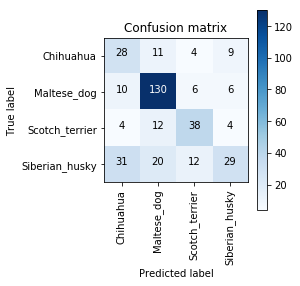

In [22]:
svc  = SVC()
svc_grid, y_pred = evaluateClassifier(svc, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

=> L'accuracy de la classification est de 63,56%.

### Logistic Regression

=> Classification accuracy: 58.19 % 

             precision    recall  f1-score   support

          0       0.31      0.42      0.36        52
          1       0.75      0.79      0.77       152
          2       0.56      0.59      0.57        58
          3       0.48      0.33      0.39        92

avg / total       0.58      0.58      0.58       354

Evaluation elapsed time : 1.37s.
Confusion matrix, without normalization


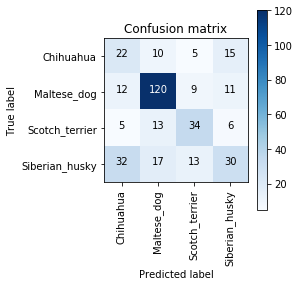

In [23]:
from sklearn.linear_model import LogisticRegression
reg  = LogisticRegression()
reg_grid, y_pred = evaluateClassifier(reg, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

=> L'accuracy de la classification est de 58.19%

### Arbre de decision

=> Classification accuracy: 43.79 % 

             precision    recall  f1-score   support

          0       0.28      0.48      0.35        52
          1       0.67      0.51      0.58       152
          2       0.35      0.43      0.39        58
          3       0.35      0.29      0.32        92

avg / total       0.48      0.44      0.45       354

Evaluation elapsed time : 0.55s.
Confusion matrix, without normalization


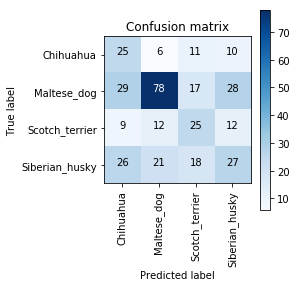

In [24]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree_grid, y_pred = evaluateClassifier(dtree, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

=> L'accuracy de la classification est de 43.79%

### Gradient Boosting

=> Classification accuracy: 61.02 % 

             precision    recall  f1-score   support

          0       0.34      0.52      0.41        52
          1       0.78      0.74      0.76       152
          2       0.64      0.64      0.64        58
          3       0.54      0.42      0.48        92

avg / total       0.63      0.61      0.62       354

Evaluation elapsed time : 15.61s.
Confusion matrix, without normalization


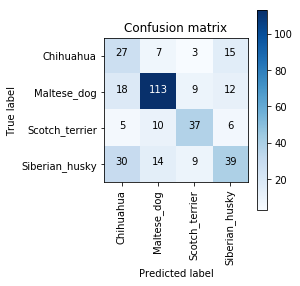

In [25]:
gboost  =  GradientBoostingClassifier()
gboost_grid, y_pred = evaluateClassifier(gboost, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

=> L'accuracy de la classification est de 61,02%.

### Random Forest

=> Classification accuracy: 48.59 % 

             precision    recall  f1-score   support

          0       0.22      0.44      0.30        52
          1       0.71      0.64      0.68       152
          2       0.53      0.55      0.54        58
          3       0.36      0.21      0.26        92

avg / total       0.52      0.49      0.49       354

Evaluation elapsed time : 1.06s.
Confusion matrix, without normalization


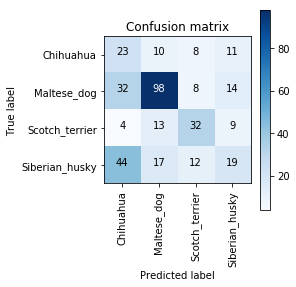

In [26]:
from sklearn.ensemble import RandomForestClassifier
rforest  =  RandomForestClassifier()
rforest_grid, y_pred = evaluateClassifier(rforest, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

=> L'accuracy de la classification est de 48,59%

### Ada Boost

=> Classification accuracy: 55.37 % 

             precision    recall  f1-score   support

          0       0.29      0.38      0.33        52
          1       0.72      0.77      0.75       152
          2       0.53      0.57      0.55        58
          3       0.43      0.28      0.34        92

avg / total       0.55      0.55      0.55       354

Evaluation elapsed time : 3.62s.
Confusion matrix, without normalization


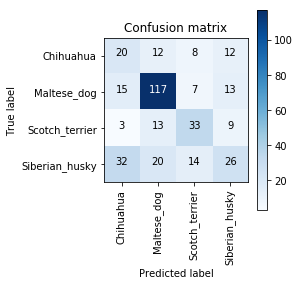

In [27]:
from sklearn.ensemble import AdaBoostClassifier
adaboost  =  AdaBoostClassifier()
adaboost_grid, y_pred = evaluateClassifier(adaboost, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

=> L'accuracy de la classification est de 55,37%.

## 3.3 Résultats

In [28]:
models = { 'Support Vector Machine' : svc_grid, 'Logistic Regression' : reg_grid, 
          'Decision Tree' : dtree_grid, 'Random Forest' : rforest_grid, 'Gradient Boosting' : gboost_grid, 'AdaBoost' : adaboost_grid}
for k, v in models.items() :
    print("{:s} : best score = {:.3f}%".format(k,v.best_score_*100))

Support Vector Machine : best score = 65.950%
Logistic Regression : best score = 57.100%
Decision Tree : best score = 47.550%
Random Forest : best score = 55.400%
Gradient Boosting : best score = 64.450%
AdaBoost : best score = 51.450%


=> C'est l'algorithme **Support Vector Machine** qui donne le meilleur résultat. C'est celui que nous conservons et que nous allons tuner.

# 4. Tuning avec pré-traitement images

- Voyons si nous améliorons la performance de notre algorithme en appliquant des traitements sur les données images en entrée.

## 4.1 Méthodes pour traitement des images

In [29]:
'''
Equalisation de l'histogramme (Contrast Limited Adaptive Histogram Equalization)
'''
def equalizeHist(img): 
    equ_img = exposure.equalize_hist(img)
    equ_img = img_as_ubyte(equ_img)
    return equ_img

In [30]:
'''
Filtre glaussian blur
'''
def gaussianBlur(img) :
    gauss_img = gaussian(img, sigma=.5, multichannel=True)
    gauss_img = img_as_ubyte(gauss_img)
    return gauss_img

In [31]:
'''
 On essaye de détourer l'image du chienOn essay 
'''
def grabCut(img) :  
    mask = np.zeros(img.shape[:2],np.uint8)
    
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    nb_iter = 2

    rect = (1,1,img.shape[1]-1,img.shape[0]-1)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,nb_iter,cv2.GC_INIT_WITH_RECT)

    fgd_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img_grabcut = img_as_ubyte(img*fgd_mask[:,:,np.newaxis])
    return img_grabcut

Quelques méthodes de pré-traitement des images.

In [32]:
'''
Applique les traitements listés dans 'preprocessing' aux images.
'''
def preprocess_images(images_list, preprocessing) :
    start_time = time()
    X_trans=[]
    for im in images_list:
        for p in preprocessing :
            im_trans = im
            if p == 'EqualizeHistogram' :
                im_trans = equalizeHist(im)
            elif p == 'GaussianBlur' :
                im_trans = gaussianBlur(im)
            elif p == 'GrabCut' :
                im_trans = grabCut(im)
            else :
                print("Error unknown processing : ", p)
        X_trans.append(im_trans)
    print("Image Preprocessing elapsed time : %0.2fs."%(time() - start_time))
    return X_trans

In [33]:
def evaluationWithPreprocessing(train_img, y_train, test_img, y_test, preprocessing, n_clusters) :
    #Train
    if len(preprocessing) :
        x_train_img = preprocess_images(train_img, preprocessing)
    else :
        x_train_img = train_img
    img_features = extractFeatures(x_train_img)
    bovw = MyBagOfVisualWords(n_clusters, img_features)
    x_train = bovw.getBagOfVisualWords(img_features)
    scaler = StandardScaler()
    x_train= scaler.fit_transform(x_train)
    
    # Test
    if len(preprocessing) :
        x_test_img = preprocess_images(test_img, preprocessing)
    else :
        x_test_img = test_img
    x_test_features = extractFeatures(x_test_img)
    x_test = bovw.getBagOfVisualWords(x_test_features)
    x_test= scaler.transform(x_test)
    
    svc  = SVC()
    svc_grid, y_pred = evaluateClassifier(svc, x_train, y_train, x_test, y_test)

## 4.2 Egalisation de l'histogramme

- Application de l'égalisation de l'histogramme.

In [34]:
evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test, ['EqualizeHistogram'], n_clusters) 

Image Preprocessing elapsed time : 73.25s.
SIFT Extraction elapsed time : 186.06s.
Vocabulary construction elapsed time : 29.30s.
BOVW elapsed time : 2.04s.
Image Preprocessing elapsed time : 9.61s.
SIFT Extraction elapsed time : 19.36s.
Vocabulary construction elapsed time : 1.80s.
BOVW elapsed time : 0.21s.
=> Classification accuracy: 56.50 % 

             precision    recall  f1-score   support

          0       0.29      0.56      0.38        52
          1       0.79      0.67      0.73       152
          2       0.62      0.69      0.66        58
          3       0.48      0.32      0.38        92

avg / total       0.61      0.56      0.57       354

Evaluation elapsed time : 5.95s.


=> La performance n'a pas été améliorée.

## 4.3 Filtre gaussien

=> Avec filtre gaussien.

In [35]:
evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test,  ['GaussianBlur'], n_clusters) 

Image Preprocessing elapsed time : 46.97s.
SIFT Extraction elapsed time : 153.92s.
Vocabulary construction elapsed time : 8.01s.
BOVW elapsed time : 0.99s.
Image Preprocessing elapsed time : 6.69s.
SIFT Extraction elapsed time : 19.11s.
Vocabulary construction elapsed time : 0.73s.
BOVW elapsed time : 0.18s.
=> Classification accuracy: 63.56 % 

             precision    recall  f1-score   support

          0       0.37      0.54      0.44        52
          1       0.75      0.84      0.79       152
          2       0.69      0.66      0.67        58
          3       0.58      0.35      0.44        92

avg / total       0.64      0.64      0.63       354

Evaluation elapsed time : 4.46s.


=> On a un meilleur score avec ce pré-traitement.

## 4.4 Grab Cut - suppression arrière plan

- Cette technique est très consommatrices de ressources. Avec notre dataset, le temps de traitement est trop long et dépasse notre patience :-) . Nous avons décidé de ne pas le tester.

In [37]:
#evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test,  ['GrabCut'], n_clusters) 

## 4.5 Résultats

=> Le pré-traitement avec le fitre gaussien améliore les performances de notre algorithmes.<br/>
=> Nous aurions pu aussi tester des combinaisons de pré-traitements pour la durée des calculs nous a un peu découragée.

# 5. Tuning du nombre de clusters

- Essayons maintenant différents nombres de clusters.

In [38]:
clusters_tuning = [100, 300, 500, 1000]
for k in clusters_tuning :
    print("\n#### Evaluation with number of clusters :", k)
    evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test,  ['GaussianBlur'], k) 


#### Evaluation with number of clusters : 100
Image Preprocessing elapsed time : 43.41s.
SIFT Extraction elapsed time : 148.06s.
Vocabulary construction elapsed time : 13.27s.
BOVW elapsed time : 1.01s.
Image Preprocessing elapsed time : 6.78s.
SIFT Extraction elapsed time : 25.41s.
Vocabulary construction elapsed time : 0.99s.
BOVW elapsed time : 0.18s.
=> Classification accuracy: 63.56 % 

             precision    recall  f1-score   support

          0       0.37      0.54      0.44        52
          1       0.75      0.84      0.79       152
          2       0.69      0.66      0.67        58
          3       0.58      0.35      0.44        92

avg / total       0.64      0.64      0.63       354

Evaluation elapsed time : 3.81s.

#### Evaluation with number of clusters : 300
Image Preprocessing elapsed time : 53.51s.
SIFT Extraction elapsed time : 192.36s.
Vocabulary construction elapsed time : 10.29s.
BOVW elapsed time : 1.55s.
Image Preprocessing elapsed time : 6.27s.
SIFT

## 5.3 Analyse résultats

=> On obtient le meilleur score avec **100 clusters**.

# 5. Tuning des hyper-paramètres.

- Nous allons maintenant essayer de "tuner" les hyper-paramètres du SVC pour trouver ceux qui donnent la meilleure performance.

In [40]:
def getImgFeatures(train_img, test_img, n_clusters, preprocessing) :
    #Train
    if len(preprocessing) :
        x_train_img = preprocess_images(train_img, preprocessing)
    else :
        x_train_img = train_img
    img_features = extractFeatures(x_train_img)
    bovw = MyBagOfVisualWords(n_clusters, img_features)
    x_train = bovw.getBagOfVisualWords(img_features)
    scaler = StandardScaler()
    x_train= scaler.fit_transform(x_train)
    
    # Test
    if len(preprocessing) :
        x_test_img = preprocess_images(test_img, preprocessing)
    else :
        x_test_img = test_img
    x_test_features = extractFeatures(x_test_img)
    x_test = bovw.getBagOfVisualWords(x_test_features)
    x_test= scaler.transform(x_test)
    
    return x_train, x_test

- On construits les features de nos données.

In [45]:
n_cluster = 100
x_train, x_test = getImgFeatures(x_train_img, x_test_img,n_cluster, ['GaussianBlur'] )

Image Preprocessing elapsed time : 51.90s.
SIFT Extraction elapsed time : 122.11s.
Vocabulary construction elapsed time : 11.85s.
BOVW elapsed time : 1.04s.
Image Preprocessing elapsed time : 5.54s.
SIFT Extraction elapsed time : 17.03s.
Vocabulary construction elapsed time : 0.73s.
BOVW elapsed time : 0.12s.


In [48]:
svc  = SVC()
parameters = [{'C':[ 0.001, 0.01, 0.1, 1, 10, 100] }]
svc_grid, y_pred = evaluateClassifier(svc, x_train, y_train, x_test, y_test, parameters=parameters)

=> Classification accuracy: 63.56 % 

             precision    recall  f1-score   support

          0       0.37      0.54      0.44        52
          1       0.75      0.84      0.79       152
          2       0.69      0.66      0.67        58
          3       0.58      0.35      0.44        92

avg / total       0.64      0.64      0.63       354

Evaluation elapsed time : 7.25s.


In [49]:
svc_grid.best_params_

{'C': 1}

=> Le score n'est pas amélioré et nous obtenons la meilleure performance avec C = 1

# 6. Visualisation features

- Visualisons les features obtenus avec la technique Bag Of VIsual Words.

## 6.1 Sans prétraitement

In [50]:
n_cluster = 100
x_train_features = extractFeatures(x_train_img)
bovw = MyBagOfVisualWords(n_clusters, x_train_features)
x_train = bovw.getBagOfVisualWords(x_train_features)
scaler = StandardScaler()
x_train= scaler.fit_transform(x_train)

SIFT Extraction elapsed time : 144.77s.
Vocabulary construction elapsed time : 11.09s.
BOVW elapsed time : 0.89s.


In [51]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(x_train)

In [52]:
def display_TSNE(tsne_results, labels, title) :
    fig, ax = plt.subplots(figsize=(8,6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar()
    plt.title(title)

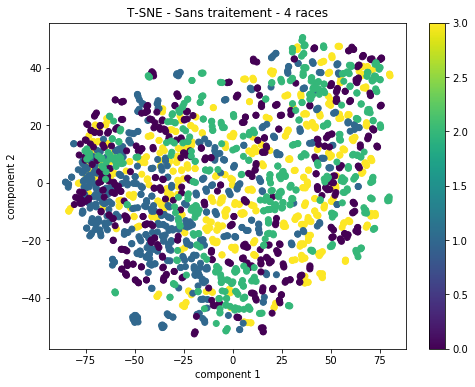

In [53]:
display_TSNE(tsne_results, y_train, 'T-SNE - Sans traitement - 4 races')

=> Les clusters ne sont pas complètement homogènes et distincs.

## 6.2 Avec égalisation histrogramme

In [54]:
prep_img = preprocess_images(x_train_img, ['EqualizeHistogram'])

Image Preprocessing elapsed time : 65.20s.


In [55]:
x_train_features = extractFeatures(prep_img)
bovw = MyBagOfVisualWords(n_clusters, x_train_features)
x_train2 = bovw.getBagOfVisualWords(x_train_features)
scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train2)

SIFT Extraction elapsed time : 196.49s.
Vocabulary construction elapsed time : 15.33s.
BOVW elapsed time : 1.40s.


In [56]:
tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(x_train2)

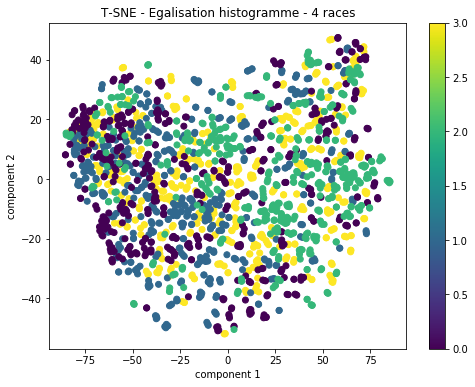

In [57]:
display_TSNE(tsne_results, y_train, 'T-SNE - Egalisation histogramme - 4 races')

=> On ne remarque pas d'amélioration.

## 6.3 Avec filtre gaussien

In [58]:
prep_img = preprocess_images(x_train_img, ['GaussianBlur'])

Image Preprocessing elapsed time : 53.98s.


In [59]:
x_train_features = extractFeatures(prep_img)
bovw = MyBagOfVisualWords(n_clusters, x_train_features)
x_train3 = bovw.getBagOfVisualWords(x_train_features)
scaler = StandardScaler()
x_train3 = scaler.fit_transform(x_train3)

SIFT Extraction elapsed time : 117.04s.
Vocabulary construction elapsed time : 8.89s.
BOVW elapsed time : 1.02s.


In [60]:
tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(x_train3)

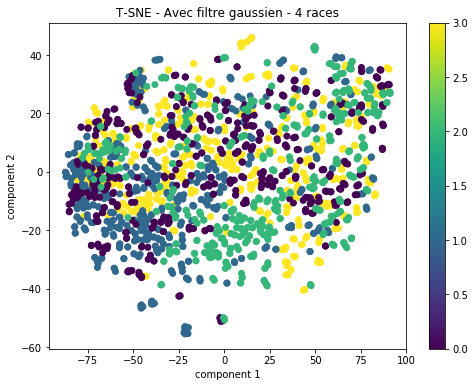

In [61]:
display_TSNE(tsne_results, y_train, 'T-SNE - Avec filtre gaussien - 4 races')

=> Une lègère amélioration par rapport aux techniques précedentes mais les clusters restent toujours peu homogène et pas très distinctes. 